In [1]:
#libraries to run in Binder
!pip install matplotlib
!pip install scipy
!pip install pandas

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, ifft
from scipy.integrate import odeint
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.linalg import eig
from scipy.linalg import toeplitz
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import pandas as pd
from matplotlib.ticker import LogLocator

c:\users\tl\anaconda3\envs\mediaenv\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# 1. Exact Solution

In [3]:


def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)

def bs_call(S,K,T,r,sigma,t):
    if S==0:
        return 0
    if T == t:
        return max(S-K,0)
    tau = T-t
    return S*norm.cdf(d1(S,K,tau,r,sigma))-K*exp(-r*tau)*norm.cdf(d2(S,K,tau,r,sigma))

def bs_call_no_sigma(S,K,T,r,sigma):
    return S-K*exp(-r*T)

In [4]:
# Exact solution when using transformed variable x=y
def exact(t,x):
    te=T-t
    S=L*(1+x)/(1-x)
    
    return bs_call(S,K,T,r,sigma,te)

# 2. Collocation solution based on Chebyshev Polynomials

In [5]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame

## 2.1. Variables definition

In [6]:
#vars 

L   = 20.0 #20 gives a reasonable Smax of 278
nx  = 64
a   = 1.0;sigma=np.sqrt(2)
cfl = 0.9
r=0.01
r_sigma=r-1/2*sigma**2
K=70

N=12
TN=NT=120
M=2#order or diff equation - constant
T = 1

## 2.2. Chebyhev differentiation matrix

In [7]:

def chebdif(N,M):
    # differentiation matrices using Chebyshev collocation. N - number of gridpoints, M -order of derivative
      
    if M >= N:
        raise Exception('numer of nodes must be greater than M')
        
    if M <= 0:
         raise Exception('derivative order must be at least 1')

    DM = np.zeros((M,N,N))
    
    n1 = int(N/2); n2 = int(round(N/2.))     # indices used for flipping trick
    k = np.arange(N)                    # compute theta vector
    th = k*np.pi/(N-1)

    # Compute the Chebyshev points

    #x = np.cos(np.pi*np.linspace(N-1,0,N)/(N-1))                # obvious way   
    x = np.sin(np.pi*((N-1)-2*np.linspace(N-1,0,N))/(2*(N-1)))   # W&R way
    x = x[::-1]
    
    # Assemble the differentiation matrices
    T = np.tile(th/2,(N,1))
    DX = 2*np.sin(T.T+T)*np.sin(T.T-T)               # trigonometric identity
    DX[n1:,:] = -np.flipud(np.fliplr(DX[0:n2,:]))    # flipping trick
    DX[range(N),range(N)]=1.                         # diagonals of D
    DX=DX.T

    C = toeplitz((-1.)**k)           # matrix with entries c(k)/c(j)
    C[0,:]  *= 2
    C[-1,:] *= 2
    C[:,0] *= 0.5
    C[:,-1] *= 0.5

    Z = 1./DX                        # Z contains entries 1/(x(k)-x(j))
    Z[range(N),range(N)] = 0.        # with zeros on the diagonal.          

    D = np.eye(N)                    # D contains differentiation matrices.
                                          
    for ell in range(M):
        D = (ell+1)*Z*(C*np.tile(np.diag(D),(N,1)).T - D)      # off-diagonals    
        D[range(N),range(N)]= -np.sum(D,axis=1)        # negative sum trick
        DM[ell,:,:] = D                                # store current D in DM

    return x,DM


## 2.3. Variable coefficients 

In [8]:
def g2(x):
    return -(1/8)*(sigma**2)*((x+1)**2)*((1-x)**2)

In [9]:
def g3(x,L):
    return -(r/2)*(x+1)*(1-x)-(1/8)*sigma**2*(x+1)**2*(1-x)*L

## 2.4. Functions

In [128]:
from itertools import combinations
def backslash(A,b):
    num_vars = A.shape[1]
    rank = np.linalg.matrix_rank(A)
    if rank == num_vars:              
        sol = np.linalg.lstsq(A, b, rcond=None)[0]    # not under-determined
    else:
        for nz in combinations(range(num_vars), rank):    # the variables not set to zero
            try: 
                sol = np.zeros((num_vars, 1))  
                sol[nz, :] = np.asarray(np.linalg.solve(A[:, nz], b))
                
            except np.linalg.LinAlgError:     
                pass                    # picked bad variables, can't solve
    return sol

In [129]:
def pend(y, t, A, tn):#only internal points 
    
    
    y_middle = y[:-1]
    y_start=y[0]#-D1.dot(y)[0]
    y_end = y[-1]#-D1.dot(y)[-1]
    
    y_hat = backslash(A,y[:-1])
    y_hat = y_hat*t/tn
    
    res = (A).dot(y_hat)
    res = np.append(np.append(y_start,res),y_end)
    # de-aliasing
    N32 = int(A.shape[1])
    N = int(A.shape[1]/3*2)
    to_remove = int((N32-N))
    
    res[-to_remove:]=0.0
    
    return res

In [111]:
def rungekutta4(f, y0, t, A):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n - 1):
        #print(y[i,1:])
        yi=y[i,1:]
        h = t[i+1] - t[i]
        
        k1 = f(yi, t[i], A, n)
        k1=k1[1:]
        k2 = f(yi + k1 * h / 2., t[i] + h / 2., A, n)
        k2=k2[1:]
        k3 = f(yi + k2 * h / 2., t[i] + h / 2., A, n)
        k3=k3[1:]
        k4 = f(yi + k3 * h, t[i] + h, A, n)
        k4=k4[1:]
        
        temp = (yi + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4))
        y[i+1] = np.insert(temp, 0, np.inf, axis=0)
        
    return y

In [91]:
def make_matrix(D,x):
    D1 = D[0,:,:]                   # first derivative
    D2 = D[1,:,:]                   # second derivative
    D0=np.identity(D.shape[1])
    #D0[0,:]=0
    D0[-1,:]=0

    for j in range(D.shape[1]):
        for i in range(D.shape[2]):
            if i== 0 or i == D.shape[1]-1:  
                D1[j,i]=D1[j,i]*(0)
                D2[j,i]=D2[j,i]*0
            else: 
                
                D1[j,i]=D1[j,i]*g3(x[j],L)
                D2[j,i]=D2[j,i]*g2(x[j])
    D0=D0*r
    
    A=D0.T+D1.T+D2.T
    A[0]=A[-1]=A[0]*0
    
    A[:,0]=D0[0]
    A[:,-1]=D0[-1]  
    
    return A

In [63]:
def cheb_int( N, TN,L ):
    N32=int(N*3/2)
    x, D = chebdif(N32, M)        # first two derivatives
    
    D1 = D[0,:,:]                   # first derivative
    D2 = D[1,:,:]                   # second derivative
    A = make_matrix(D,x)
    A = A[1:-1,1:-1]
    
    #get initial values
    y0 = [max(L*(xi+1)/(1-xi)-K,0) for xi in x[1:]]
    y0 = [np.inf]+y0
    y0[-1] = 0 #boundary
    
    t4 = np.linspace(0, T, TN)
    t4 = np.flip(t4)
    sol4 = rungekutta4(pend, y0, t4, A)
    
    return (t4,x,sol4)

## 2.5. Implementation

In [100]:
x, D = chebdif(N, M) 
A=make_matrix(D,x)

In [131]:
# boundary values for y where y is S ported to [-1,1]
y0=[L*(1+x1)/(1-x1) for x1 in x[1:]]
y0=[np.inf] + y0

In [132]:
(t4,x,sol4)=cheb_int( N, NT, L )


###   2.5.1. How the solution behaves with time

In [133]:
t4.shape

(120,)

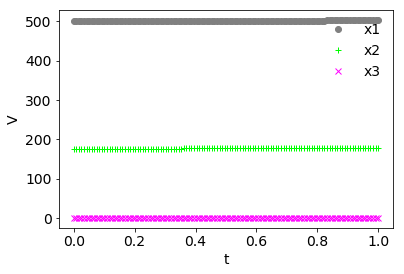

In [134]:
fig,ax=plt.subplots()

#ax.plot(t4,sol4[:,0], ':', color='blue', lw=1)
ax.plot(t4,sol4[:,2], 'o', color='gray', lw=1)
ax.plot(t4,sol4[:,3], '+', color='lime', lw=1)
ax.plot(t4,sol4[:,-1], 'x', color='magenta', lw=1)
    
plt.rc('font', size=14)
#plt.gca().set_xlim([0,10])
#plt.gca().set_ylim([0,28000])
plt.xlabel('t')
plt.ylabel(r'V');
plt.legend(['x1', 'x2', 'x3'], frameon=False);

### 2.5.2. How the solution behaves in space (S or x)

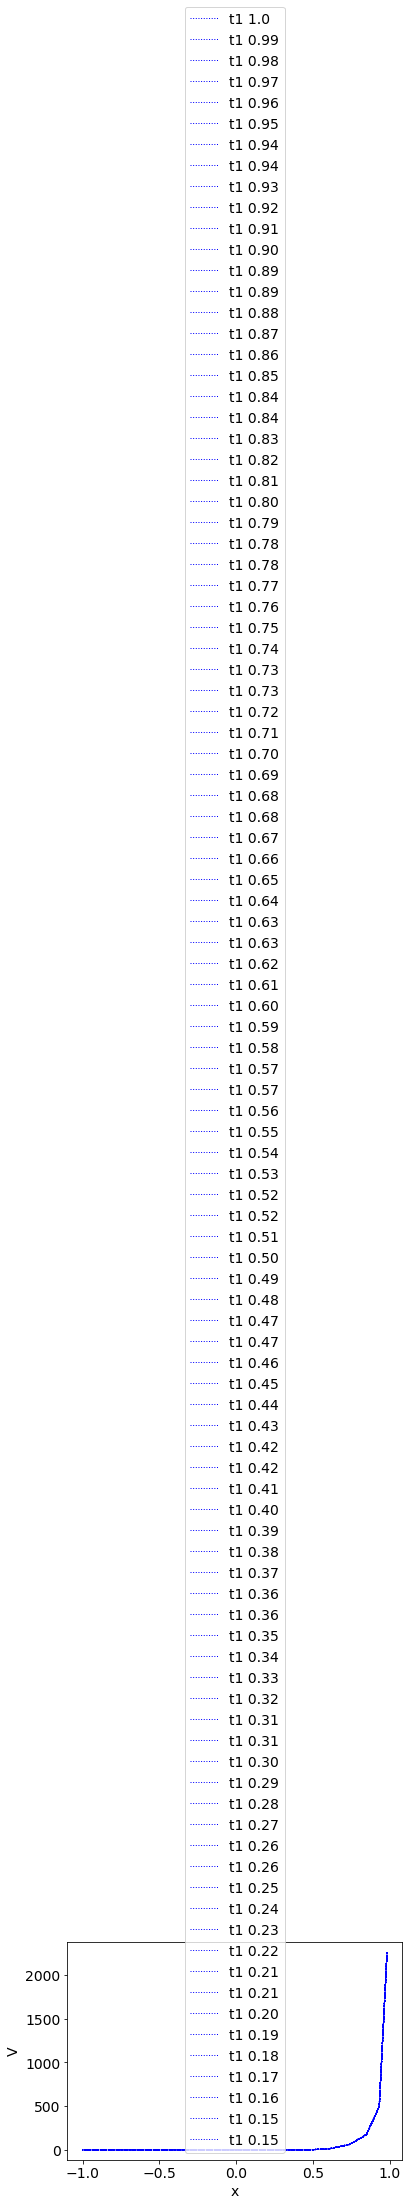

In [135]:
fig,ax=plt.subplots()
legend = []
for ix in range(len(t4)-18):
    ax.plot(x,sol4[ix,], ':', color='blue', lw=1)

    plt.rc('font', size=14)
    #plt.gca().set_xlim([0,10])
    #plt.gca().set_ylim([0,500])
    plt.xlabel('x')
    plt.ylabel(r'V');
    legend.append(r't1 '+str(t4[ix])[:4])
    plt.legend(legend, frameon=True);

## 3. Visualize approximation vs Exact

In [136]:
# Visualizing in terms of S
S=[L*(1+xi)/(1-xi) for xi in x[1:]]
S=[np.inf]+S

In [137]:
Smax=S[1]
Smax

2329.223831549756

In [138]:
# Uncommit this line on a local machine to be able to rotate the graphs. 
#After running this cell, all graphs will start opening in a new window (not the browser, QuickTime window). To disable this behavior and see the graphs in the cells again, it is necessary to restart the kernel (menu Kernel->Restart)


#%matplotlib qt

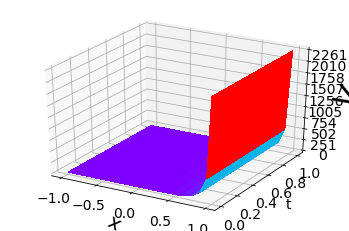

In [139]:
# Make data.

x, D = chebdif(N, M)        # first two derivatives

A=make_matrix(D,x)

(t4,x,sol4)=cheb_int( N, NT, L )
# without infinity point
xn=x[1:]
X, Y = np.meshgrid(xn, t4)

Z = np.zeros((len(t4),len(xn)))
for i in range(len(t4)):
    for j in range(len(xn)):
        Z[i,j]=exact(t4[i],xn[j])
        
        
# Plot the surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.rainbow,
                       linewidth=0, antialiased=False)

surf = ax.plot_surface(X, Y, sol4[:,1:], rstride=1, cstride=1,
                        cmap=cm.coolwarm,
                        alpha=1,
                       linewidth=0, antialiased=False)
# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.set_xlabel('x', fontsize=20, rotation=150)
ax.set_ylabel('t')
ax.set_zlabel(r'V', fontsize=30, rotation=60)
# A StrMethodFormatter is used automatically

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


# 5. Studying Convergence of the Error

In [140]:
 # using the same data as in the plot above

In [141]:
sol4Z = sol4[:,1:]

In [142]:
np.linalg.norm(sol4Z - Z, np.inf)/np.linalg.norm(Z, np.inf)

0.04287278210798173

In [143]:
pd.DataFrame(np.abs((sol4Z-Z))).to_csv("errors.csv")

## 5.1. Error as a function of number of x points (S dimension)

In [ ]:
Nmin = 4
n = Nmin
i = 1

ns=[]
err=[]

norminf=[]
while ( n <= 205 ):  
    x, D = chebdif(n, M)        # first two derivatives

    A=make_matrix(D,x)

    (t4,x,sol4)=cheb_int( n, NT, L )
    sol4Z = sol4[:,1:]
    xn=x[1:]
    
    Z = np.zeros((len(t4),len(xn)))
    for i in range(len(t4)):
        for j in range(len(xn)):
            Z[i,j]=exact(t4[i],xn[j])
    norminf.append(np.linalg.norm(sol4Z - Z, np.inf)/np.linalg.norm(Z, np.inf))
    ns.append(n)
    n = n * 2;
# Plotting the error;
fig,ax=plt.subplots()

ax.plot(ns,norminf, ':', color='red', lw=1)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.yaxis.set_major_locator(LogLocator(base = 10))

plt.rc('font', size=14)
#plt.gca().set_xlim([0,10])
plt.xlabel('N')
plt.ylabel('error');

plt.legend(['Infinity norm'], frameon=True);

## 5.2. Error as a function of max time intervals TN

In [ ]:
# For  t
Nmin = 40
t = tmin = 15

ts=[]
err=[]

norminf=[]
while ( t <= 125 ):  
    x, D = chebdif(Nmin, M)        # first two derivatives

    A=make_matrix(D,x)

    (t4,x,sol4)=cheb_int( Nmin, t, L )
    sol4Z = sol4[:,1:]
    xn=x[1:]
    
    Z = np.zeros((len(t4),len(xn)))
    for i in range(len(t4)):
        for j in range(len(xn)):
            Z[i,j]=exact(t4[i],xn[j])
    norminf.append(np.linalg.norm(sol4Z - Z, np.inf)/np.linalg.norm(Z, np.inf))
    ts.append(t)
    t = t + 5;
# Plotting the error;
fig,ax=plt.subplots()

ax.plot(ts,norminf, ':', color='red', lw=1)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.yaxis.set_major_locator(LogLocator(base = 10))
plt.rc('font', size=14)
#plt.gca().set_xlim([0,10])
plt.xlabel('T')
plt.ylabel('error');

plt.legend(['Infinity norm'], frameon=True);

## 5.3. Error as a function of L

In [ ]:
#dependence on L
l = 4
Nmin = 40
t = tmin = 15

ls=[]
err=[]

norminf=[]
while ( l <= 40 ):  
    x, D = chebdif(Nmin, M)        

    A=make_matrix(D,x)

    (t4,x,sol4)=cheb_int( Nmin, t, l )
    sol4Z = sol4[:,1:]
    xn=x[1:]
    
    Z = np.zeros((len(t4),len(xn)))
    for i in range(len(t4)):
        for j in range(len(xn)):
            Z[i,j]=exact(t4[i],xn[j])
    norminf.append(np.linalg.norm(sol4Z - Z, np.inf)/np.linalg.norm(Z, np.inf))
    ls.append(l)
    l = l + 1;
# Plotting the error;
fig,ax=plt.subplots()

ax.plot(ls,norminf, ':', color='red', lw=1)

ax.set_yscale('log')

plt.rc('font', size=14)

plt.xlabel('L')
plt.ylabel('error');

plt.legend(['Infinity norm'], frameon=True);